# Combining published ncRNA locations - produce ncRNA gff for RNAseq

Before analysing the differential expression of sRNA we need to define them. There have been a number of publications on this topic, however there is no comprehensive list of sRNAs. Arnvig, Cortes and Young published a list of fewer than 20 molecules in their 2014 chapter "Noncoding RNA in Mycobacteria". Similarly the 27th release of Tuberculist (ver 2.6) lists 32 sRNAs. A number of other publications add a considerable number to the roster, however the quality of these varies, making it hard to discern real sRNAs from false positives.

I will take a inclusive approach and test everything, including antisense transcripts, intergenic and UTR RNA. By doing so, anything that is not affected will produce no signal, while those that are de facto differentially expressed will provide the relevant signal. I will pay the cost of multiple comparison testing. 

The (naive) alternative is to re-analyse with normal annotation but reverse the orientation to identify genes whose antisense expression is increased. In this case I will pay the cost of signal dilution due to the smaller size of ncRNA when compared to the CDS (e.g. 50-100bp vs 1kb).

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")
import os

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
import cobra.test

mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

legend_size=text_size=12
title_size=axis_size=14

In [2]:
#define paths
external_path = '../data/external/'
interim_path = '../data/interim/'
processed_path = '../data/processed/'

#load data
arnvig = pd.read_csv('{}Arnvig_sRNA_confirmed.csv'.format(external_path), index_col=0)
tuberculist = pd.read_csv('{}Tuberculist_annotated_sRNA.csv'.format(external_path), index_col=0)
miotto = pd.read_csv('{}Miotto_sRNA_candidates.csv'.format(external_path), index_col=0)
dichiara = pd.read_csv('{}DiChiara_sRNA_candidates.csv'.format(external_path), index_col=0)
namouchi = pd.read_csv('{}Namouchi_sRNA_candidates.csv'.format(external_path), index_col=0)
sipht = pd.read_csv('{}SIPHT_sRNA_candidates.csv'.format(external_path), index_col=0)

In [3]:
for x in [arnvig, tuberculist, miotto, dichiara, namouchi, sipht]:
    print(x.columns)

Index(['name', 'New annotation', 'Other', 'Tuberculist', 'Rfam', 'Strand',
       'Flanking CDSs', 'Verified by', '5_ (RACE)', '5_ (TSS)', '3_',
       'Expression', 'Conservation', 'start', 'stop'],
      dtype='object')
Index(['tuberculist_ID', 'name', 'type', 'start', 'end', 'strand'], dtype='object')
Index(['Candidate ID', 'Start', 'End', 'Strand', 'Type', 'Length',
       'mean reads coverage', 'mean conservation', '-10 promoter consensus',
       'Terminator', 'MFE p-val', 'Array p-val', 'p-adj',
       'Relative position to CDSs', 'Within', 'Antisense to',
       'DistClosestGeneUP', 'DistClosestGeneDOWN', 'Northern_validation'],
      dtype='object')
Index(['Name', 'Start', 'End', 'Strand', 'Type', 'TB_validated'], dtype='object')
Index(['name', 'start', 'stop', 'length', 'orientation', 'sRNA_type',
       'location', 'targeted gene(s)', 'gene function(s)', 'COG', 'Source',
       'Northern_validated'],
      dtype='object')
Index(['sRNAName', 'sRNAstart', 'end', 'dirsRNA', 'le

## Validated consolidation
Take arnvig, tuberculist, miotto(validated), dichiara(valdiated) and namouchi (validated) and consolidate them. Remove duplicates.

I think for this I will add them all to a dummy MTB stranded genome and look for regions of overlap (multiple coverage) and resolve them.

In [145]:
tier1 = pd.DataFrame({'name': list(arnvig.name)+list(tuberculist.name)+list(miotto[miotto.Northern_validation==1]['Candidate ID'])+list(dichiara[dichiara.TB_validated==1]['Name'])+list(namouchi[namouchi.Northern_validated==1]['name']), 
                      'start': list(arnvig.start)+list(tuberculist.start)+list(miotto[miotto.Northern_validation==1]['Start'])+list(dichiara[dichiara.TB_validated==1]['Start'])+list(namouchi[namouchi.Northern_validated==1]['start']), 
                      'end': list(arnvig.stop)+list(tuberculist.end)+list(miotto[miotto.Northern_validation==1]['End'])+list(dichiara[dichiara.TB_validated==1]['End'])+list(namouchi[namouchi.Northern_validated==1]['stop']), 
                      'strand': list(arnvig.Strand)+list(tuberculist.strand)+list(miotto[miotto.Northern_validation==1]['Strand'])+list(dichiara[dichiara.TB_validated==1]['Strand'])+list(namouchi[namouchi.Northern_validated==1]['orientation']),
                      'source':['Arnvig14',]*len(arnvig)+['Tuberculist',]*len(tuberculist)+['Miotto13',]*len(miotto[miotto.Northern_validation==1])+['DiChiara10',]*len(dichiara[dichiara.TB_validated==1])+['Namouchi16',]*len(namouchi[namouchi.Northern_validated==1])})

tier1.head()

,end,name,source,start,strand
0,293705,arnvig01,Arnvig14,293602,1
1,704247,arnvig02,Arnvig14,704187,1
2,786164,arnvig03,Arnvig14,786038,0
3,786164,arnvig04,Arnvig14,786090,0
4,1175315,arnvig05,Arnvig14,1174124,1


In [5]:
mtb_dummy = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1.start),list(tier1.end),list(tier1.strand)):
    mtb_dummy[_strand,_start:_end]+=1

In [6]:
print(Counter(mtb_dummy[0]))
print(Counter(mtb_dummy[1]))

Counter({0.0: 4405250, 1.0: 6218, 2.0: 64})
Counter({0.0: 4399519, 1.0: 9693, 2.0: 2114, 3.0: 206})


Looks like there are overlapping sRNAs... check out the duplciates in [0].

In [7]:
np.where(mtb_dummy[0]==2)

(array([1275993, 1275994, 1275995, 1275996, 1275997, 1275998, 1275999,
        1276000, 1276001, 1276002, 1276003, 1276004, 1276005, 1276006,
        1276007, 1276008, 1276009, 1276010, 1276011, 1276012, 1276013,
        1276014, 1276015, 1276016, 1276017, 1276018, 1276019, 1276020,
        1276021, 1276022, 1276023, 1276024, 1276025, 1276026, 1276027,
        1276028, 1276029, 1276030, 1276031, 1276032, 1276033, 1276034,
        1276035, 1276036, 1276037, 1276038, 1276039, 1276040, 1276041,
        1276042, 1276043, 1276044, 1276045, 1276046, 1276047, 1276048,
        1276049, 1276050, 1276051, 1276052, 1276053, 1276054, 1276055,
        1276056]),)

They belong to the same range. Pick a value somewhere in the middle: 1276056

In [8]:
chk = 1276056
print(tier1[(tier1.start<=chk)&(tier1.end>=chk)])

       end      name    start  strand
7  1276057  arnvig08  1275957       0
8  1276057  arnvig09  1275993       0


This would be less straightforward for [1]. But we can see how many duplicates we have from a plot of the genomic loci that are duplicated.

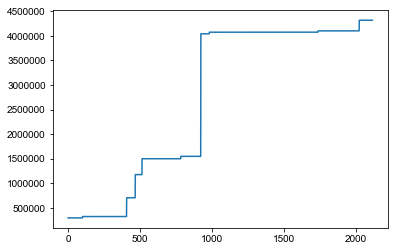

In [9]:
a = list(np.where(mtb_dummy[1]==2)[0])
plt.plot(a)

Based on this there are 10 duplicated sRNAs in [1]. 

In [10]:
#Duplicates in 0 - picked a number in the middle of the above range
F_2 = [1276056]
#duplicates in 1 - did the same as above for the other strand
R_2 = [293642, 321590, 704210, 1175202, 1498165, 
       1547215, 4040920, 4100800, 4073650, 4317151]

R_3 = [1175275, 1960712]

duplicated = F_2 + R_2 + R_3

Print out the relevant sRNAs.

In [11]:
for chk in duplicated:
        print('\n--------\nPosition in overlap: {}\n--------\n'.format(chk))
        print(tier1[(tier1.start<=chk)&(tier1.end>=chk)])


--------
Position in overlap: 1276056
--------

       end      name    start  strand
7  1276057  arnvig08  1275957       0
8  1276057  arnvig09  1275993       0

--------
Position in overlap: 293642
--------

       end      name   start  strand
0   293705  arnvig01  293602       1
23  293705        F6  293604       1

--------
Position in overlap: 321590
--------

       end   name   start  strand
81  321829  Mcr14  321523       1
91  321829  Mpr13  321523       1

--------
Position in overlap: 704210
--------

       end      name   start  strand
1   704247  arnvig02  704187       1
24  704247       B55  704187       1

--------
Position in overlap: 1175202
--------

       end      name    start  strand
4  1175315  arnvig05  1174124       1
5  1175315  arnvig06  1175178       1

--------
Position in overlap: 1498165
--------

        end  name    start  strand
75  1498360  Mcr3  1498091       1
88  1498360  Mpr7  1498091       1

--------
Position in overlap: 1547215
--------

   

In [12]:
suspend = ['arnvig09', 'arnvig05', 'mpr5', 'arnvig16', 
           'MTS1338', 'arnvig01', 'Mpr13', 'arnvig02', 
           'Mpr7', 'arnvig11', 'arnvig23', 'arnvig21',
           'Mpr4', 'arnvig22']

tier1['keep'] = [int(x not in suspend) for x in tier1.name]

In [13]:
mtb_dummy2 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1[tier1.keep==1].start),
                                   list(tier1[tier1.keep==1].end),
                                   list(tier1[tier1.keep==1].strand)):
    mtb_dummy2[_strand,_start:_end]+=1

In [14]:
print(Counter(mtb_dummy2[0]))
print(Counter(mtb_dummy2[1]))

Counter({0.0: 4405250, 1.0: 6282})
Counter({0.0: 4400676, 1.0: 10856})


OK, this worked. But I need an automatic way of doing this going forward (for tier2 sRNAs).

Try a numerical approach on these data...

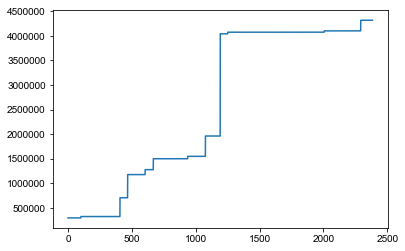

In [15]:
#Get all the duplicated loci and sort them
overlaps = sorted(list(np.where(mtb_dummy[1]>1)[0])+list(np.where(mtb_dummy[0]>1)[0]))

#Plot them out
plt.plot(overlaps)

Once I have the loci sorted like this I would expect that congruous duplicated sRNA loci have a increment of 1, while any duplications further along have an increment of more than that. So if I start from the first duplicated position I should be able to define the starts of every other duplicated position because: 

``x[i]-x[i-1]>1``

In [146]:
overlap_sRNA_starts = [overlaps[0]]
for ind,val in enumerate(overlaps[1:]):
    if val-overlaps[ind]>1: overlap_sRNA_starts.append(val)

In [17]:
overlap_sRNA_starts

[293604,
 321523,
 704187,
 1175178,
 1275993,
 1498091,
 1547129,
 1960667,
 4040879,
 4073623,
 4100682,
 4317073]

In [18]:
for chk in overlap_sRNA_starts:
        print('\n--------\nPosition in overlap: {}\n--------\n'.format(chk))
        print(tier1[(tier1.start<=chk)&(tier1.end>=chk)])


--------
Position in overlap: 293604
--------

       end      name   start  strand  keep
0   293705  arnvig01  293602       1     0
23  293705        F6  293604       1     1

--------
Position in overlap: 321523
--------

       end   name   start  strand  keep
81  321829  Mcr14  321523       1     1
91  321829  Mpr13  321523       1     0

--------
Position in overlap: 704187
--------

       end      name   start  strand  keep
1   704247  arnvig02  704187       1     0
24  704247       B55  704187       1     1

--------
Position in overlap: 1175178
--------

       end      name    start  strand  keep
4  1175315  arnvig05  1174124       1     0
5  1175315  arnvig06  1175178       1     1

--------
Position in overlap: 1275993
--------

       end      name    start  strand  keep
7  1276057  arnvig08  1275957       0     1
8  1276057  arnvig09  1275993       0     0

--------
Position in overlap: 1498091
--------

        end  name    start  strand  keep
75  1498360  Mcr3  1498091

Seems to work. Just as a reality check let's just do a strand-naive analysis...

In [19]:
mtb_dummy3 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1.start),list(tier1.end),list(tier1.strand)):
    if _start>_end: mtb_dummy3[0,_end:_start]+=1
    if _start<_end: mtb_dummy3[1,_start:_end]+=1
        
print(Counter(mtb_dummy3[0]))
print(Counter(mtb_dummy3[1]))

Counter({0.0: 4410708, 1.0: 684, 2.0: 140})
Counter({0.0: 4393237, 1.0: 15911, 2.0: 2178, 3.0: 206})


The numbers don't add up... most of the sRNAs seem to be in the forward orientation. Let's check where the strand derived from the external data does not match up with the strand from the naive approach.

In [20]:
issues = []
for (_start, _end, _strand, _index) in zip(list(tier1.start),list(tier1.end),list(tier1.strand),list(tier1.index)):
    
    _predicted_strand=1
    
    if _start>_end: 
        _predicted_strand=0
        
    if _predicted_strand!=_strand:
        print(_predicted_strand, _strand, _index)
        issues.append(_index)

tier1['problem'] = [int(x in issues) for x in tier1.index]
tier1[tier1.problem==1]

1 0 7
1 0 8
1 0 16
1 0 26
1 0 27
1 0 30
1 0 31
1 0 35
1 0 36
1 0 37
1 0 39
1 0 40
1 0 47
1 0 48
1 0 66
1 0 67
1 0 68
1 0 69
1 0 70
1 0 71
1 0 72
1 0 73
1 0 74
1 0 76
1 0 77
1 0 80
1 0 82
1 0 83
1 0 92
1 0 95
1 0 96


,end,name,start,strand,keep,problem
7,1276057,arnvig08,1275957,0,1,1
8,1276057,arnvig09,1275993,0,0,1
16,2029427,arnvig17,2028973,0,1,1
26,1915190,G2,1914962,0,1,1
27,1952503,AS1726,1952291,0,1,1
30,4099478,B11,4099386,0,1,1
31,4168281,C8,4168154,0,1,1
35,1413224,mcr11,1413094,0,1,1
36,1413237,mcr11,1413232,0,1,1
37,1413260,mcr11,1413255,0,1,1


In [30]:
#clean up
tier1.drop('problem', 1, inplace=True)
del temp1

Clearly there is something going on here... these need to be manually checked! Looks like all of the problematic species are supposed to be on the reverse strand though...

Having looked through the files for Tuberculist, Namouchi and DiChiara, none of them reverse the start and end for reverse strand sRNAs. So there we can invert. The situation for Arnvig is less clear, however it seems that this was done for the majority of the sRNAs just not the three highlighted above.

As a result, trust the strand annotation not the start/stop annotation. I guess I'll have to correct the dataframe to reflect this.

Perhaps easiest if I make the start-stop coordinates such that __start is always smaller than stop__.

## Correct sRNA orientation annotation

Start by identifying situations where this is not the case.

In [21]:
len(tier1[tier1.start>tier1.end])

7

In [22]:
#Get coordinates and find where things don't add up
_starts = list(tier1.start)
_ends = list(tier1.end)
change = np.where(np.array(_starts)>np.array(_ends))[0]

#replace the starts and ends such that the convetion is kept
for x in change:
    _starts[x], _ends[x] = _ends[x],_starts[x]
    
#update the values in the dataframe
tier1.start = _starts
tier1.end = _ends

#cleanup
del _starts, _ends, change

#check
len(tier1[tier1.start>tier1.end])

0

Worked fine, now let's update the external data, as I clearly made an inputing mistake.

In [23]:
#Get coordinates and find where things don't add up
_starts = list(arnvig.start)
_ends = list(arnvig.stop)
change = np.where(np.array(_starts)>np.array(_ends))[0]

#replace the starts and ends such that the convetion is kept
for x in change:
    _starts[x], _ends[x] = _ends[x],_starts[x]
    
#update the values in the dataframe
arnvig.start = _starts
arnvig.stop = _ends

#cleanup
del _starts, _ends, change

arnvig.to_csv('{}Arnvig2_sRNA_confirmed.csv'.format(external_path))

In [24]:
mtb_dummy = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1.start),list(tier1.end),list(tier1.strand)):
    mtb_dummy[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy[0]))
print(Counter(mtb_dummy[1]))

Counter({0.0: 4404863, 1.0: 6094, 2.0: 509, 3.0: 66})
Counter({0.0: 4399519, 1.0: 9693, 2.0: 2114, 3.0: 206})


## Identify overlapping _Tier1_ sRNA

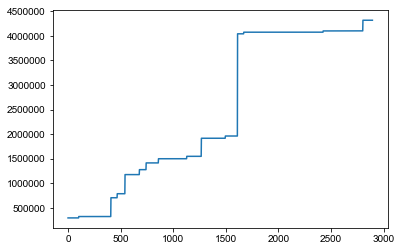

In [25]:
#Get all the duplicated loci and sort them
overlaps = sorted(list(np.where(mtb_dummy[1]>1)[0])+list(np.where(mtb_dummy[0]>1)[0]))

#Plot them out
plt.plot(overlaps)

In [27]:
overlap_sRNA_starts = [overlaps[0]]
for ind,val in enumerate(overlaps[1:]):
    if val-overlaps[ind]>1: overlap_sRNA_starts.append(val)
        
print(len(overlap_sRNA_starts))
print(overlap_sRNA_starts)

16
[293604, 321523, 704187, 786090, 1175178, 1275993, 1413107, 1498091, 1547129, 1914962, 1960667, 4040879, 4073623, 4099386, 4100682, 4317073]


Next decide which ones of the overlap to keep. Above I've stuck to the ones that have proper names, but that cannot be done automatically. Could do:
- shortest sRNA
- longest sRNA
- random sRNA

Let's say that the shortest sRNA is the most conservative approach that should not ablate true signal.

In [28]:
#create a copy of tier1, add sRNA length to it and sort it.
temp1 = tier1.copy()
temp1['length'] = temp1.end-temp1.start
temp1.sort_values('length', inplace=True, ascending=True) #for keeping the largest change "ascending" to False

_keep = [1,]*len(temp1)

#For random removal do this on tier1 not temp1
for chk in overlap_sRNA_starts:
    if len(temp1[(temp1.start<=chk)&(temp1.end>=chk)])>1:
        for x in temp1[(temp1.start<=chk)&(temp1.end>=chk)].index[1:]:
            _keep[x]=0
            
tier1['keep'] = _keep

tier1.head()

,end,name,start,strand,keep,problem
0,293705,arnvig01,293602,1,0,0
1,704247,arnvig02,704187,1,1,0
2,786164,arnvig03,786038,0,0,0
3,786164,arnvig04,786090,0,1,0
4,1175315,arnvig05,1174124,1,0,0


Actually, this would be best done with a function...

In [5]:
def flag_duplicates(sRNA_df, remove=True, keep='shortest'):
    """
    Find duplicate sRNAs and flag them. 
    
    Duplicates can be removed based on simple criterion 
    of length.
    
    INPUT:
    ------
    sRNA_df: DataFrame of sRNA with 'start', 'end' and 'strand'
    remove: bool, False - mark duplicates, True - remove duplicates
    keep: str, 'shortest'|'longest'|'random', criterion defining what
          sRNA to keep.
          
    OUTPUT:
    -------
    flags: list, a list of 0/1 based on whether or not to keep a given
            species.
    """
    
    _mtb_dummy = np.zeros((2,4411532))

    for (_start, _end, _strand) in zip(list(sRNA_df.start),list(sRNA_df.end),list(sRNA_df.strand)):
        _mtb_dummy[_strand,_start:_end]+=1
    
    _overlaps = sorted([(x,0) for x in np.where(_mtb_dummy[0]>1)[0]]+[(x,1) for x in np.where(_mtb_dummy[1]>1)[0]])
        
    _overlap_sRNA_starts = [_overlaps[0]]
    for ind,val in enumerate(_overlaps[1:]):
        if val[0]-_overlaps[ind][0]>1: 
            _overlap_sRNA_starts.append(val)
            
    _temp = sRNA_df.copy()
    _temp['length'] = _temp.end-_temp.start
    
    if keep=='shortest':
        _temp.sort_values('length', inplace=True, ascending=True)
    if keep=='longest':
        _temp.sort_values('length', inplace=True, ascending=False)
    if keep=='random':
        pass #don't do anything, just take whichever is first.
    
    if remove==True:
        _flag = [1,]*len(_temp)
    if remove==False:
        _flag = [0,]*len(_temp)

    for (_chk, _orientation) in _overlap_sRNA_starts:
        if len(_temp[(_temp.start<=_chk)&(_temp.end>=_chk)&(_temp.strand==_orientation)])>1:
            
            if remove==True:
                for x in _temp[(_temp.start<=_chk)&(_temp.end>=_chk)&(_temp.strand==_orientation)].index[1:]:
                    _flag[x]=0
                    
            if remove==False:
                for x in _temp[(_temp.start<=_chk)&(_temp.end>=_chk)&(_temp.strand==_orientation)].index:
                    _flag[x]=1
                    
    return _flag
            

In [147]:
tier1['keep'] = flag_duplicates(tier1)

In [148]:
mtb_dummy = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1[tier1.keep==1].start),
                                   list(tier1[tier1.keep==1].end),
                                   list(tier1[tier1.keep==1].strand)):
    mtb_dummy[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy[0]))
print(Counter(mtb_dummy[1]))

Counter({0.0: 4405126, 1.0: 6406})
Counter({0.0: 4400742, 1.0: 10700, 2.0: 90})


Something has gone wrong... What happaned?

In [149]:
np.where(mtb_dummy[1]==2)[0]

array([1175225, 1175226, 1175227, 1175228, 1175229, 1175230, 1175231,
       1175232, 1175233, 1175234, 1175235, 1175236, 1175237, 1175238,
       1175239, 1175240, 1175241, 1175242, 1175243, 1175244, 1175245,
       1175246, 1175247, 1175248, 1175249, 1175250, 1175251, 1175252,
       1175253, 1175254, 1175255, 1175256, 1175257, 1175258, 1175259,
       1175260, 1175261, 1175262, 1175263, 1175264, 1175265, 1175266,
       1175267, 1175268, 1175269, 1175270, 1175271, 1175272, 1175273,
       1175274, 1175275, 1175276, 1175277, 1175278, 1175279, 1175280,
       1175281, 1175282, 1175283, 1175284, 1175285, 1175286, 1175287,
       1175288, 1175289, 1175290, 1175291, 1175292, 1175293, 1175294,
       1175295, 1175296, 1175297, 1175298, 1175299, 1175300, 1175301,
       1175302, 1175303, 1175304, 1175305, 1175306, 1175307, 1175308,
       1175309, 1175310, 1175311, 1175312, 1175313, 1175314])

In [150]:
tier1[(tier1.start<=1175225)&(tier1.end>=1175225)]

,end,name,source,start,strand,keep
4,1175315,arnvig05,Arnvig14,1174124,1,0
5,1175315,arnvig06,Arnvig14,1175178,1,1
33,1175315,mpr5,Tuberculist,1175225,1,1


I see what happened - I had three different overlapping sRNAs, and only 2 got picked up as duplicates with the third one flying under the radar. This needs to be fixed manually, lest I recode everything... So need to make sure to do a QC with the sums at the end of each filtering.

In [151]:
tier1.keep[tier1.name=='arnvig06']=0

mtb_dummy = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier1[tier1.keep==1].start),
                                   list(tier1[tier1.keep==1].end),
                                   list(tier1[tier1.keep==1].strand)):
    mtb_dummy[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy[0]))
print(Counter(mtb_dummy[1]))

Counter({0.0: 4405126, 1.0: 6406})
Counter({0.0: 4400789, 1.0: 10743})


Good, save.

In [152]:
tier1.to_csv('{}sRNA_tier1.csv'.format(interim_path))

## Generate a list of tier2 sRNAs

In [153]:
tier2 = pd.DataFrame({'name': list(miotto[miotto.Northern_validation!=1]['Candidate ID'])+list(dichiara[dichiara.TB_validated!=1]['Name'])+list(namouchi[namouchi.Northern_validated!=1]['name']), 
                      'start': list(miotto[miotto.Northern_validation!=1]['Start'])+list(dichiara[dichiara.TB_validated!=1]['Start'])+list(namouchi[namouchi.Northern_validated!=1]['start']), 
                      'end': list(miotto[miotto.Northern_validation!=1]['End'])+list(dichiara[dichiara.TB_validated!=1]['End'])+list(namouchi[namouchi.Northern_validated!=1]['stop']), 
                      'strand': list(miotto[miotto.Northern_validation!=1]['Strand'])+list(dichiara[dichiara.TB_validated!=1]['Strand'])+list(namouchi[namouchi.Northern_validated!=1]['orientation']),
                      'source': ['Miotto13',]*len(miotto[miotto.Northern_validation!=1])+['DiChiara10',]*len(dichiara[dichiara.TB_validated!=1])+['Namouchi16',]*len(namouchi[namouchi.Northern_validated!=1])})

tier2.head()

,end,name,source,start,strand
0,23998,candidate_1,Miotto13,23850,1
1,24157,candidate_2,Miotto13,24046,1
2,24787,candidate_3,Miotto13,24672,1
3,25274,candidate_4,Miotto13,24867,1
4,51056,candidate_5,Miotto13,50563,1


In [96]:
mtb_dummy2 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier2.start),list(tier2.end),list(tier2.strand)):
    mtb_dummy2[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy2[0]))
print(Counter(mtb_dummy2[1]))

Counter({0.0: 4329554, 1.0: 79219, 2.0: 2667, 3.0: 92})
Counter({0.0: 4345485, 1.0: 63844, 2.0: 2025, 3.0: 178})


In [97]:
#Reality check 1
len(tier2[tier2.start>tier2.end])

0

In [154]:
tier2['keep'] = flag_duplicates(tier2)

tier2.head()

,end,name,source,start,strand,keep
0,23998,candidate_1,Miotto13,23850,1,1
1,24157,candidate_2,Miotto13,24046,1,1
2,24787,candidate_3,Miotto13,24672,1,1
3,25274,candidate_4,Miotto13,24867,1,1
4,51056,candidate_5,Miotto13,50563,1,1


In [99]:
#Reality check 2
mtb_dummy2 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier2[tier2.keep==1].start),
                                   list(tier2[tier2.keep==1].end),
                                   list(tier2[tier2.keep==1].strand)):
    mtb_dummy2[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy2[0]))
print(Counter(mtb_dummy2[1]))

Counter({0.0: 4332635, 1.0: 78805, 2.0: 92})
Counter({0.0: 4346905, 1.0: 64542, 2.0: 85})


In [155]:
Counter(tier2.keep)

Counter({0: 70, 1: 2075})

I can run the function twice, but I will run into indexing issues... so I have to reindex based on a descending keep and then change the keep values based on that...

In [156]:
#I think I can run the function twice...
tier2.sort_values('keep', ascending=False, inplace=True)
tier2.reset_index(inplace=True, drop=True)
tier2.keep[tier2.keep==1]=flag_duplicates(tier2[tier2.keep==1])

In [157]:
tier2.head()

,end,name,source,start,strand,keep
0,23998,candidate_1,Miotto13,23850,1,1
1,2726695,candidate_1424,Miotto13,2726660,0,1
2,2710084,candidate_1422,Miotto13,2710046,0,1
3,2698817,candidate_1421,Miotto13,2698780,0,1
4,2698745,candidate_1420,Miotto13,2698715,0,1


In [158]:
Counter(tier2.keep)

Counter({0: 73, 1: 2072})

In [159]:
#Reality check 2
mtb_dummy2 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(tier2[tier2.keep==1].start),
                                   list(tier2[tier2.keep==1].end),
                                   list(tier2[tier2.keep==1].strand)):
    mtb_dummy2[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy2[0]))
print(Counter(mtb_dummy2[1]))

Counter({0.0: 4332715, 1.0: 78817})
Counter({0.0: 4346917, 1.0: 64615})


This worked. So instead of a curated deletion I can run the function twice, keeping track of the indices. Save the tier2 sRNAs.

In [160]:
tier2.to_csv('{}sRNA_tier2.csv'.format(interim_path))

## Create a federated sRNA list

Bring in all the Tier1 and Tier2 sRNAs into a single file.

In [3]:
tier1 = pd.read_csv('{}sRNA_tier1.csv'.format(interim_path), index_col=0)
tier2 = pd.read_csv('{}sRNA_tier2.csv'.format(interim_path), index_col=0)

#label which tier a given sRNA belongs to.
tier1['tier'] = [1,]*len(tier1)
tier2['tier'] = [2,]*len(tier2)

#Federate the sRNAs and reset the indeces
sRNA_candidates = pd.concat([tier1[tier1.keep==1],tier2[tier2.keep==1]])
sRNA_candidates.sort_values('start', inplace=True)
sRNA_candidates.reset_index(inplace=True, drop=True)

In [6]:
#Find duplicates
sRNA_candidates['duplicates'] = flag_duplicates(sRNA_candidates, remove=False)

#Discard all tier2 sRNAs that are already included as tier1
sRNA_candidates.keep[(sRNA_candidates.duplicates==1)&(sRNA_candidates.tier==2)]=0

In [7]:
#Reality check
mtb_dummy3 = np.zeros((2,4411532))

for (_start, _end, _strand) in zip(list(sRNA_candidates[sRNA_candidates.keep==1].start),
                                   list(sRNA_candidates[sRNA_candidates.keep==1].end),
                                   list(sRNA_candidates[sRNA_candidates.keep==1].strand)):
    mtb_dummy3[_strand,_start:_end]+=1
    
print(Counter(mtb_dummy3[0]))
print(Counter(mtb_dummy3[1]))

Counter({0.0: 4328074, 1.0: 83458})
Counter({0.0: 4337559, 1.0: 73973})


Worked!

Next let's generate the type of output that would be useful for RNAseq.

## New PTT

Needs to have the form of:

``MTB_anc RefSeq  exon    1       1524    .       +       .       ID=MTB_anc:dnaA;gene_id=Rv0001;db_xref=GeneID:885041``

These correspond to (see <a href='http://www.ensembl.org/info/website/upload/gff.html'>Ensembl</a>):

### Fields

Fields must be tab-separated. Also, all but the final field in each feature line must contain a value; "empty" columns should be denoted with a '.'

- __seqname__ - name of the chromosome or scaffold; chromosome names can be given with or without the 'chr' prefix. _Important note_: the seqname must be one used within Ensembl, i.e. a standard chromosome name or an Ensembl identifier such as a scaffold ID, without any additional content such as species or assembly. See the example GFF output below.
- __source__ - name of the program that generated this feature, or the data source (database or project name)
- __feature__ - feature type name, e.g. Gene, Variation, Similarity
- __start__ - Start position of the feature, with sequence numbering starting at 1.
- __end__ - End position of the feature, with sequence numbering starting at 1.
- __score__ - A floating point value.
- __strand__ - defined as + (forward) or - (reverse).
- __frame__ - One of '0', '1' or '2'. '0' indicates that the first base of the feature is the first base of a codon, '1' that the second base is the first base of a codon, and so on..
- __attribute__ - A semicolon-separated list of tag-value pairs, providing additional information about each feature.

Keep in mind that by default, htseq-count expects gene_id in the "attribute" field. This can be changed by setting the `--idattr` parameter, but I'll keep it simple just in case.

In [8]:
#save the sRNA_candidates DataFrame
sRNA_candidates.to_csv('{}sRNA_candidates.csv'.format(processed_path))

#Write output
output_file = open('{}MTB_sRNA_collated.gff'.format(processed_path), 'w')

#Create a dictionary to translate my strand annotation to the +/- convention
strnd = {0:'-', 1:'+'}

#write output
for row in sRNA_candidates.iterrows():
    _row=row[1]
    _line='MTB_anc\t{}\texon\t{}\t{}\t.\t{}\t.\tgene_id={};tier={}\n'.format(_row['source'],
                                                                             _row['start'],
                                                                             _row['end'],
                                                                             strnd[_row['strand']],
                                                                             _row['name'],
                                                                             _row['tier'])
    output_file.write(_line)

output_file.close()

Looks good, let's try it out now...